### Polynomial regression

***Polynomial regression*** models the relationship between a dependent variable $y$ and one o more independent variables $X$, assuming possible non-linear relationships between the independent variables and the dependent variable.

The mathematica expression of a polynomial regression can be represented as:

 $y = \beta_{0} + \\
 \beta_{1}\,x_1 + \beta_{11}\,x_1\,x_1 + \beta_{12}\,x_1\,x_2 + \dots + \beta_{111}\,x_1\,x_1\,x_1 + \dots +\\
 \beta_{2}\,x_2 + \beta_{22}\,x_2\,x_2 + \beta_{23}\,x_2\,x_3 + \dots + \beta_{222}\,x_2\,x_2\,x_2 + \dots +\\
 \dots \\
 \beta_{m}\,x_m + \beta_{mm}\,x_m\,x_m + \beta_{mmm}\,x_m\,x_m\,x_m + \dots$

where we can have many different terms with any possible combination of features.

The goal of polynomial regression is to estimate the values of the coefficients $\beta_{...}$ that minimize the sum of squared differences between the observed and predicted values of 𝑦. This is a two step approach:

- generate the ***polynomial features***
- apply multivariate linear regression on the collection of polynomial features

The fitted line is a ***curve*** (not a straight line) and represents the best estimate of the relationship between the independent and dependent variables based on the given data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### polynomial features
- create new features that result from the combination of the original features up to a given degree

In [2]:
from sklearn.preprocessing import PolynomialFeatures

In [3]:
X = np.arange(12).reshape(4, 3)
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [4]:
pf = PolynomialFeatures(degree = 2)
pf.fit(X)

PolynomialFeatures()

In [5]:
pf.transform(X)

array([[  1.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   2.,   4.],
       [  1.,   3.,   4.,   5.,   9.,  12.,  15.,  16.,  20.,  25.],
       [  1.,   6.,   7.,   8.,  36.,  42.,  48.,  49.,  56.,  64.],
       [  1.,   9.,  10.,  11.,  81.,  90.,  99., 100., 110., 121.]])

### scikit-learn pipeline

- a ***pipeline*** is an object with a sequence of steps to process the data
- in our case we create a pipeline to generate the polynomial features and perform a linear regression on them

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [7]:
pipeline = make_pipeline(PolynomialFeatures(degree = 2), LinearRegression())
pipeline

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

### example: sèrie climàtica Girona 1950/2022

In [8]:
df = pd.read_csv('../../data/girona/girona_raw.txt', delimiter = '\t')
df.head()

,ANY,MES,DIA,PPT,TX,TN
0,1950,1,1,0.0,12.7,5.2
1,1950,1,2,0.0,13.2,-2.5
2,1950,1,3,0.0,14.8,-1.8
3,1950,1,4,0.0,15.4,0.5
4,1950,1,5,0.0,15.7,-1.8


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26663 entries, 0 to 26662
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ANY     26663 non-null  int64  
 1   MES     26663 non-null  int64  
 2   DIA     26663 non-null  int64  
 3   PPT     26663 non-null  float64
 4   TX      26663 non-null  float64
 5   TN      26663 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1.2 MB


- a simple plot of the data does not give any clue about any tendency in the data

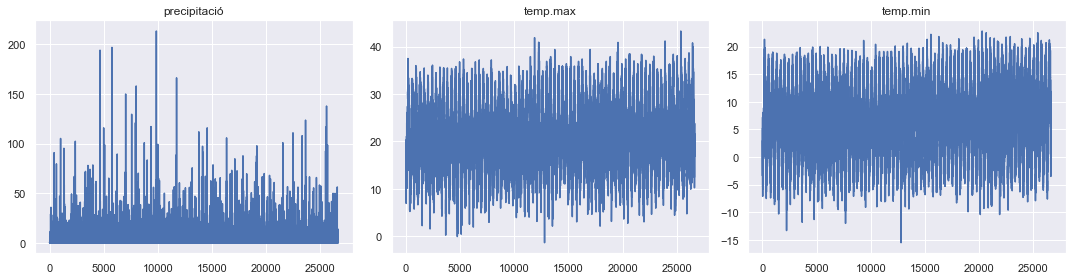

In [10]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4), sharex = True)
#
axs[0].set_title('precipitació')
axs[0].plot(df.PPT)
axs[1].set_title('temp.max')
axs[1].plot(df.TX)
axs[2].set_title('temp.min')
axs[2].plot(df.TN)
plt.tight_layout()

### compute a regression curve

- considering a $degree=2$ polynomial our model is: $y = \beta_0 + \beta_1\,x + \beta_2\,x$
- with a single dpendent variable $X$ that represents time (in days)

In [11]:
D = (df.ANY *10000 + df.MES *100 + df.DIA).to_numpy()

- we need to reshape it to pass it through the pipeline
- the *dates* do not convey any information related to the independent variables, so we replace *days* by a simple enumeration

In [12]:
X = np.arange(D.shape[0]).reshape(-1, 1)

##### create a pipeline

In [13]:
degree = 2
pipeline = make_pipeline(PolynomialFeatures(degree = degree, include_bias = False), LinearRegression())

- take the independent variable $Y$ equal to PPT

In [14]:
Y = df.PPT.to_numpy().reshape(-1, 1)

- fit/predict the data

In [15]:
pipeline.fit(X, Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [16]:
ppt_regression = pipeline.predict(X)

- model coeficients

In [17]:
ppt_model = pipeline.steps[1][1]

In [18]:
ppt_model.intercept_, ppt_model.coef_

(array([2.04982005]), array([[ 2.86956242e-05, -1.51408901e-09]]))

- thus our model is:

In [19]:
print('y = %6.4f + %6.4e x + %6.4e x^2' %(ppt_model.intercept_, ppt_model.coef_[0][0], ppt_model.coef_[0][1]))

y = 2.0498 + 2.8696e-05 x + -1.5141e-09 x^2


##### do the same with TX and TN

In [20]:
Y = df.TX.to_numpy().reshape(-1, 1)
tx_regression = pipeline.fit(X, Y).predict(X)

In [21]:
Y = df.TN.to_numpy().reshape(-1, 1)
tn_regression = pipeline.fit(X, Y).predict(X)

#### plot the regression curves over the data

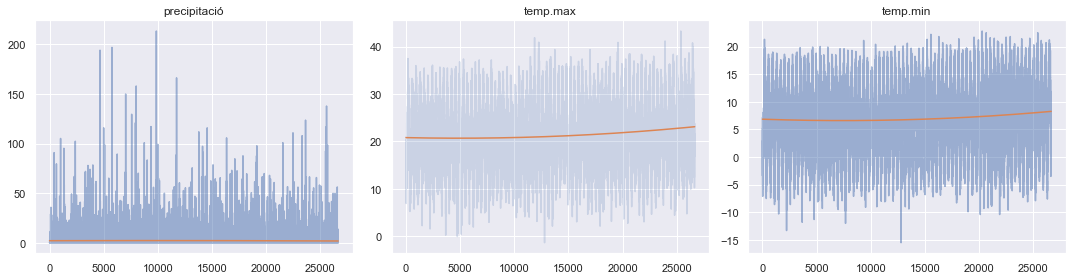

In [22]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4), sharex = True)
#
axs[0].set_title('precipitació')
axs[0].plot(X, df.PPT, alpha = 0.5)
axs[0].plot(X, ppt_regression)
axs[1].set_title('temp.max')
axs[1].plot(X, df.TX, alpha = 0.2)
axs[1].plot(X, tx_regression)
axs[2].set_title('temp.min')
axs[2].plot(X, df.TN, alpha = 0.5)
axs[2].plot(X, tn_regression)
plt.tight_layout()

### compute a regression over the yearly means

- taking the means over years usually helps visualizing the trend or making more robust predictions

In [23]:
years = pd.unique(df.ANY)
X_ = np.arange(years.shape[0]).reshape(-1, 1)

In [24]:
PPT_ = df.groupby(df.ANY).PPT.mean().to_numpy().reshape(-1, 1)
ppt_regression = pipeline.fit(X_, PPT_).predict(X_)
TX_ = df.groupby(df.ANY).TX.mean().to_numpy().reshape(-1, 1)
tx_regression = pipeline.fit(X_, TX_).predict(X_)
TN_ = df.groupby(df.ANY).TN.mean().to_numpy().reshape(-1, 1)
tn_regression = pipeline.fit(X_, TN_).predict(X_)

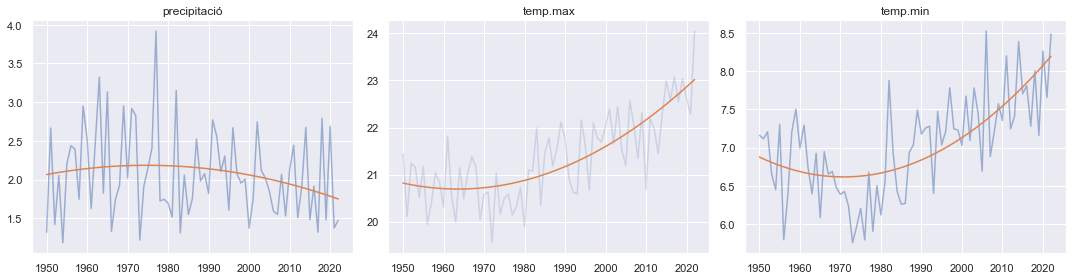

In [25]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
#
axs[0].set_title('precipitació')
axs[0].plot(years, PPT_, alpha = 0.5)
axs[0].plot(years, ppt_regression)
axs[1].set_title('temp.max')
axs[1].plot(years, TX_, alpha = 0.2)
axs[1].plot(years, tx_regression)
axs[2].set_title('temp.min')
axs[2].plot(years, TN_, alpha = 0.5)
axs[2].plot(years, tn_regression)
plt.tight_layout()